# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA


In [2]:
Xtest = pd.read_csv('../data/interimStarcraft_Xtest',index_col=0)
Xtrain = pd.read_csv('../data/interimStarcraft_Xtrain',index_col=0)
ytest = pd.read_csv('../data/interimStarcraft_ytest',index_col=0)
ytrain = pd.read_csv('../data/interimStarcraft_ytrain',index_col=0)

In [3]:
ytrain=ytrain['LeagueIndex']
ytest=ytest['LeagueIndex']
starcraft = pd.read_csv('../data/interimStarcraft_cleaned.csv',index_col = 0)
starcraft['LogHours'] = np.log(starcraft['TotalHours'])

# Model Selection
In the following notebook, we will be using a few different models along with their respective hyperparameter tuning to determine which model is best suited for our data set.

# Random Forest

In [13]:
maxDepth = list(range(1,50))
maxDepth.append(None)
paramGrid = {'criterion':['gini','entropy'],'max_depth':maxDepth,'min_samples_leaf':np.arange(1,50)}
rf = RandomForestClassifier(random_state=42)
rf_cv = GridSearchCV(rf,paramGrid,cv=5)
rf_cv.fit(X=Xtrain,y=ytrain)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [14]:
rf_cv.best_params_

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 15}

In [15]:
rf_cv.best_score_

0.42286147704590815

# Logisitic Regression

In [16]:
cParamRange = [0.001,0.01,0.1,1,10,100]
lr = LogisticRegression(random_state=42,solver='newton-cg',max_iter = 1000)
lr_cv = GridSearchCV(lr,{'C':cParamRange},cv=5)
lr_cv.fit(Xtrain,ytrain)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, random_state=42,
                                          solver='newton-cg'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]})

In [17]:
lr_cv.best_params_

{'C': 0.1}

In [18]:
lr_cv.best_score_

0.4288654690618762

# KNN

In [19]:
nNeighbors = [1,3,5,7,9,11]
paramGrid = {'n_neighbors':nNeighbors,'weights':['uniform', 'distance']}
knn=KNeighborsClassifier()
knn_cv = GridSearchCV(knn,paramGrid,cv=5)
knn_cv.fit(Xtrain,ytrain)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']})

In [20]:
knn_cv.best_params_

{'n_neighbors': 9, 'weights': 'distance'}

In [21]:
knn_cv.best_score_

0.3656998003992015

# SVM

In [34]:
paramGrid = {'C': [0.1, 1, 10, 100, 1000],'gamma': [1, 0.1, 0.01, 0.001, 0.0001],'kernel': ['rbf']}
svm = SVC(random_state=42)
svm_cv = GridSearchCV(svm,paramGrid,cv=5)
svm_cv.fit(Xtrain,ytrain)
print(svm_cv.best_params_)
print(svm_cv.best_score_)

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.4220670658682635


# Logisitic Regression VS Random Forest VS SVM
It seems that Logistic Regression, Random Forest and SVM out perform KNN. We will now run each model on our test set and check various metrics to evaluate model performance.

Logisitic Regression accuracy score: 0.41077844311377243
Random Forest accuracy score: 0.4035928143712575
SVM accuracy score: 0.4311377245508982


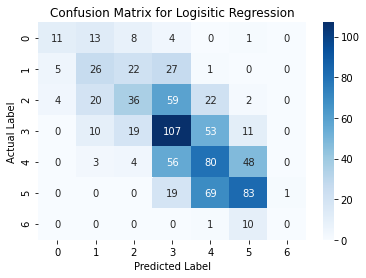

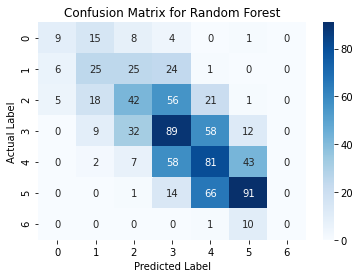

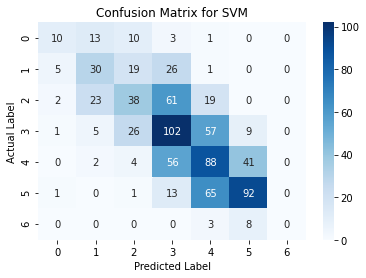

In [4]:
lr = LogisticRegression(C=.1,random_state=42,solver='newton-cg',max_iter = 1000)
rf = RandomForestClassifier(random_state=42,criterion='entropy',max_depth=6,min_samples_leaf=15)
svm = SVC(random_state=42,C=1000,gamma=.001,kernel='rbf')
lr.fit(Xtrain,ytrain)
rf.fit(Xtrain,ytrain)
svm.fit(Xtrain,ytrain)
ypredLR = lr.predict(Xtest)
ypredRF = rf.predict(Xtest)
ypredSVM= svm.predict(Xtest)
print('Logisitic Regression accuracy score: '+str(lr.score(Xtest,ytest)))
print('Random Forest accuracy score: '+str(rf.score(Xtest,ytest)))
print('SVM accuracy score: '+str(svm.score(Xtest,ytest)))
lrCnfMatrix = confusion_matrix(ytest,ypredLR)
rfCnfMatrix = confusion_matrix(ytest,ypredRF)
svmCnfMatrix = confusion_matrix(ytest,ypredSVM)
group_counts = ['{0:0.0f}'.format(value) for value in
                lrCnfMatrix.flatten()]
labels = [f'{v1}' for v1 in group_counts]
labels = np.asarray(labels).reshape(7,7)
ax = sns.heatmap(lrCnfMatrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
plt.title('Confusion Matrix for Logisitic Regression')
plt.show()
group_counts = ['{0:0.0f}'.format(value) for value in
                rfCnfMatrix.flatten()]
labels = [f'{v1}' for v1 in group_counts]
labels = np.asarray(labels).reshape(7,7)
ax = sns.heatmap(rfCnfMatrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
plt.title('Confusion Matrix for Random Forest')
plt.show()
group_counts = ['{0:0.0f}'.format(value) for value in
                svmCnfMatrix.flatten()]
labels = [f'{v1}' for v1 in group_counts]
labels = np.asarray(labels).reshape(7,7)
ax = sns.heatmap(svmCnfMatrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
plt.title('Confusion Matrix for SVM')
plt.show()

# Conclusion
The task of predicting League Index is a classification problem. We implemented 4 different machine learning algorithms and applied hyperparameter tuning through cross validation to determine which were viable models for use on our test set. We found that Random Forest, Logisitic Regression, and Support Vector Machines out performed KNN, though were all relatively closely grouped. We applied all three models to our test set and found their mean accuracy scores as well as plotted their confusion matrices. SVM seems to slightly outperform Random Forest and Logistic Regression, though all three models opperate in the low 40% range.

# Use Case
A low 40% accuracy score isn't very confidence inspiring, fortunately the case where we need to take a set of features and predict League Index is rather uncommon. The predicitons here are best used as a check in. Frequently when playing Starcraft II a player will feel like their league isn't a true reflection of their skill due to bad luck or any other number of factors out of their control. These predicitons are then useful to determine what your true league might be. Should it match with your actual league, it means their is skill improvement necessary and we can consult our feature importances for where to focus our time. Should we be prediciting a higher league, its an indicator that the player may have indeed hit a string of bad luck, or other factors outside of their control which influence their league index.

# Smurf Detection
In Starcraft, Smurfing is the practice of a high ranking player making a new account and playing in leagues well below their skill level. We will engineer a variable in our data to check low league and high league then use machine learning to determine if a new player has features that predict them in the proper low league or show that they should be higher ranked.

In [4]:
#create the league low variable.
starcraft['LowLeague'] = np.where(starcraft['LeagueIndex']<3,0,1)
starcraft.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,...,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed,LogHours,LowLeague
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,...,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000,8.006368,1
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,...,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208,8.517193,1
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,...,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189,5.298317,1
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,...,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384,5.991465,1
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,...,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019,6.214608,1


In [5]:
#Scale the features, ignoring game ID as its not a meaningful feature and of course not scaling league index as its the target
starcraft2 = starcraft.reset_index(drop=True)
star_scale = starcraft2.copy(deep=True)
feat_names = ['Age','HoursPerWeek','TotalHours','APM','SelectByHotkeys','AssignToHotkeys','UniqueHotkeys','MinimapAttacks','MinimapRightClicks','NumberOfPACs','GapBetweenPACs','ActionLatency','ActionsInPAC','TotalMapExplored','WorkersMade','UniqueUnitsMade','ComplexUnitsMade','ComplexAbilitiesUsed','LogHours']
for col in feat_names:
    scaler = RobustScaler()
    star_scale[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(star_scale[col])))
star_scale.shape

(3337, 22)

In [6]:
y = starcraft['LowLeague']
X = star_scale[feat_names]
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,random_state=42)

Logisitic Regression accuracy score: 0.8850299401197604
Random Forest accuracy score: 0.8778443113772455
SVM accuracy score: 0.8826347305389222


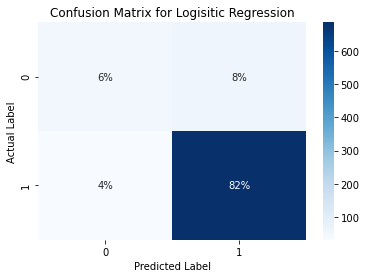

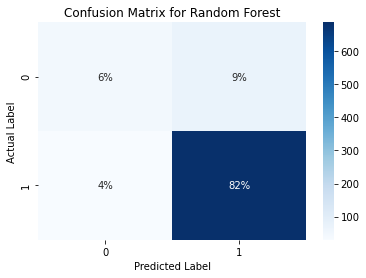

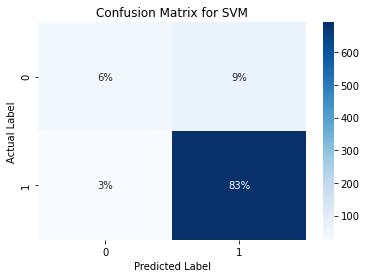

In [7]:
lr = LogisticRegression(C=.1,random_state=42,solver='newton-cg',max_iter = 1000)
rf = RandomForestClassifier(random_state=42,criterion='entropy',max_depth=6,min_samples_leaf=15)
svm = SVC(random_state=42,C=1000,gamma=.001,kernel='rbf',probability=True)
lr.fit(Xtrain,ytrain)
rf.fit(Xtrain,ytrain)
svm.fit(Xtrain,ytrain)
ypredLR = lr.predict(Xtest)
ypredRF = rf.predict(Xtest)
ypredSVM= svm.predict(Xtest)
print('Logisitic Regression accuracy score: '+str(lr.score(Xtest,ytest)))
print('Random Forest accuracy score: '+str(rf.score(Xtest,ytest)))
print('SVM accuracy score: '+str(svm.score(Xtest,ytest)))
lrCnfMatrix = confusion_matrix(ytest,ypredLR)
rfCnfMatrix = confusion_matrix(ytest,ypredRF)
svmCnfMatrix = confusion_matrix(ytest,ypredSVM)
group_counts = ['{0:0.0f}%'.format(value*100/sum(lrCnfMatrix.flatten())) for value in
                lrCnfMatrix.flatten()]
labels = [f'{v1}' for v1 in group_counts]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(lrCnfMatrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
plt.title('Confusion Matrix for Logisitic Regression')
plt.show()
group_counts = ['{0:0.0f}%'.format(value*100/sum(rfCnfMatrix.flatten())) for value in
                rfCnfMatrix.flatten()]
labels = [f'{v1}' for v1 in group_counts]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(rfCnfMatrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
plt.title('Confusion Matrix for Random Forest')
plt.show()
group_counts = ['{0:0.0f}%'.format(value*100/sum(svmCnfMatrix.flatten())) for value in
                svmCnfMatrix.flatten()]
labels = [f'{v1}' for v1 in group_counts]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(svmCnfMatrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
plt.title('Confusion Matrix for SVM')
plt.show()

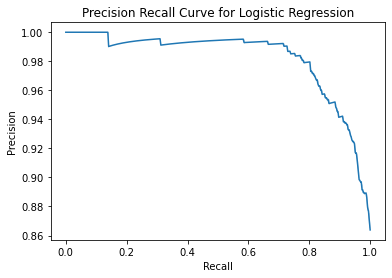

In [8]:
lr_probs = lr.predict_proba(Xtest)
lr_probs = lr_probs[:, 1]
precision, recall, thresholds = precision_recall_curve(ytest,lr_probs)
fpr, tpr, threshRate = roc_curve(ytest,lr_probs)
sns.lineplot(y=precision,x=recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve for Logistic Regression')
plt.show()

In [9]:
auc = roc_auc_score(ytest, lr_probs)
print('AUC: %.3f' % auc)
print(len(fpr),len(threshRate))


AUC: 0.906
132 132


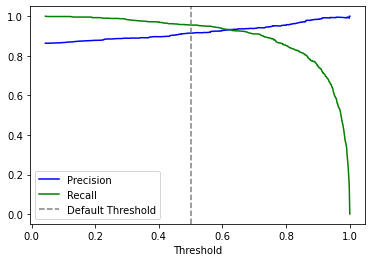

In [10]:
plt.plot(thresholds,precision[:len(precision)-1],color='blue',label='Precision')
plt.plot(thresholds,recall[:len(precision)-1],color='green',label='Recall')
plt.axvline(x=.5,color = 'gray',linestyle='--',label='Default Threshold')
plt.xlabel('Threshold')
plt.legend()
plt.show()

Given the assumption that smurfing is VERY bad, we are assuming the business response to this data is to ban smurfing players, which means we should favor Precision over Recall. We will plot the F0.5 score along side percision and recall and find its maximum.

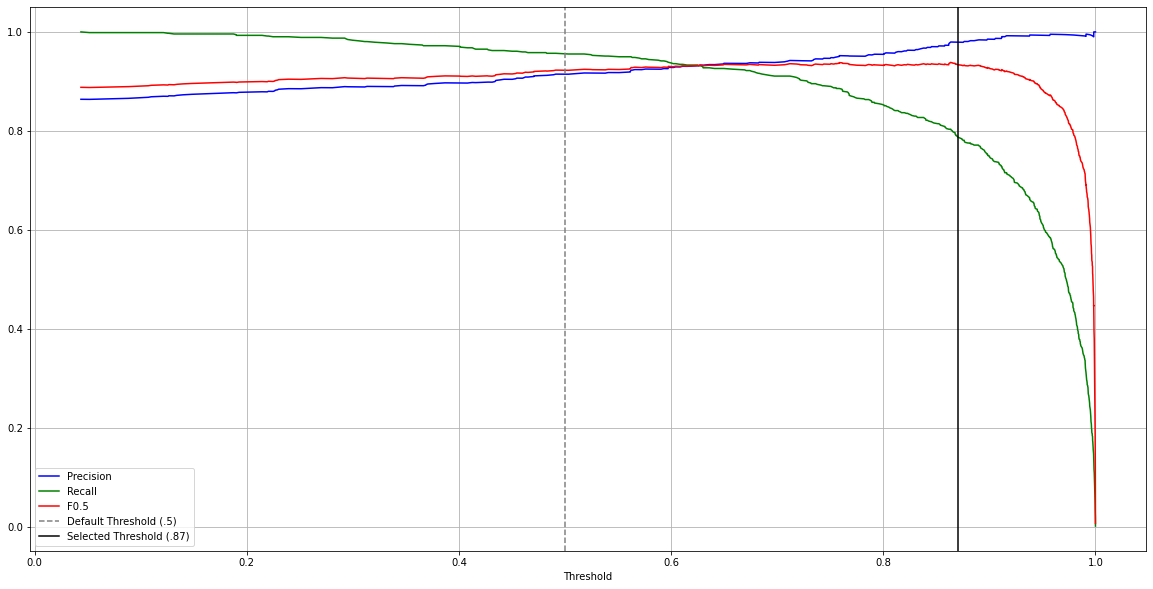

In [11]:
f5vals = []
for prec,rec in zip(precision,recall):
    f5vals.append(((1 + .5**2) * prec * rec) / (.5**2 * prec + rec))
plt.figure(figsize=(20, 10))
plt.grid()
plt.plot(thresholds,precision[:len(precision)-1],color='blue',label='Precision')
plt.plot(thresholds,recall[:len(precision)-1],color='green',label='Recall')
plt.plot(thresholds,f5vals[:len(precision)-1],color='red',label='F0.5')
plt.axvline(x=.5,color = 'gray',linestyle='--',label='Default Threshold (.5)')
plt.axvline(x=.87,color='black',label='Selected Threshold (.87)')
plt.xlabel('Threshold')
plt.legend()
plt.show()

In [12]:
def predWithThresh(thresh, x, model):
    proba = model.predict_proba(x)
    proba = proba[:, 1]
    thresholded = []
    for prob in proba:
        if prob >= thresh:
            thresholded.append(1)
        else:
            thresholded.append(0)
    return np.array(thresholded)
ythresh = predWithThresh(.87,Xtest,lr)
print(classification_report(ytest,ythresh))
lrCnfMatrix = confusion_matrix(ytest,ythresh)

              precision    recall  f1-score   support

           0       0.41      0.90      0.56       118
           1       0.98      0.79      0.87       717

    accuracy                           0.80       835
   macro avg       0.69      0.84      0.72       835
weighted avg       0.90      0.80      0.83       835



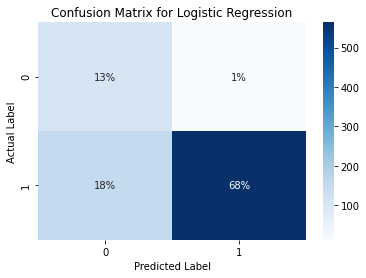

In [13]:
group_counts = ['{0:0.0f}%'.format(value*100/sum(lrCnfMatrix.flatten())) for value in
                lrCnfMatrix.flatten()]
labels = [f'{v1}' for v1 in group_counts]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(lrCnfMatrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [14]:
ylist = ytest.tolist()
toExamine = []
for loc in range(len(ylist)):
    if ylist[loc]!=ythresh[loc]:
        toExamine.append(loc)
pd.set_option('display.max_rows', None)        
Xtest.iloc[toExamine]

,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed,LogHours
321,-0.6,-0.500000,-0.640,-0.275664,-0.182245,-0.018271,0.000000,-0.340088,0.961238,0.232654,0.394155,0.002311,-0.534258,-0.5,-0.172757,-0.333333,0.000000,-0.112267,-1.041620
727,1.8,-0.333333,0.600,-0.736245,-0.408709,-0.041585,0.000000,0.137836,-0.430715,-0.611715,0.666231,0.901599,-0.447905,-0.4,-0.457592,0.333333,0.000000,-0.112267,0.479190
134,-1.0,0.000000,0.200,-0.416631,-0.441317,-0.825313,-1.000000,-0.220762,-0.754365,-0.033513,0.631539,0.227923,-0.394451,-0.2,-0.181537,0.333333,0.000000,1.522686,0.185885
905,0.6,1.333333,0.200,-0.609080,0.011424,-0.458109,0.000000,0.176914,-0.436080,-0.706724,0.841659,0.276223,-0.405832,-1.0,-0.753896,-0.333333,0.447753,0.639049,0.185885
1913,-0.2,0.000000,0.102,-0.615251,-0.073675,-0.048147,-0.666667,-0.340088,-0.230362,-0.035517,0.793237,0.413524,-0.942752,0.5,-0.459327,1.000000,2.381559,1.396452,0.099025
1689,2.0,-0.333333,-0.200,-0.346833,-0.337571,0.139929,-1.000000,-0.215423,0.416053,-0.763598,0.806988,1.266723,0.814326,-0.2,0.273625,0.666667,0.000000,-0.073446,-0.227505
486,-0.6,-0.333333,-0.500,-0.288293,0.168142,0.680862,0.666667,0.331716,1.106776,0.085900,-0.240162,-0.007756,-0.537882,1.8,-0.642235,1.666667,0.436365,0.863989,-0.706695
139,0.0,-0.833333,-0.900,-1.147957,-0.554056,-0.808449,-1.333333,-0.215359,-0.332032,-1.431632,1.286796,3.371967,-0.498075,-0.4,-0.782405,0.000000,0.000000,-0.112267,-2.347590
567,-1.0,1.333333,-0.100,0.042638,0.503371,-0.805305,-0.333333,-0.340088,0.690580,-0.563901,-0.233578,0.091991,0.525198,-0.7,0.082960,-0.333333,0.000000,-0.112267,-0.107420
1370,0.4,-0.666667,0.000,-0.808547,-0.259438,0.022966,-1.333333,1.264300,1.196382,-0.922451,0.565956,1.555948,-0.305493,-0.3,-0.351692,0.333333,0.000000,0.537218,0.000000


In [15]:
ytest.iloc[toExamine]

321     1
727     1
134     1
905     1
1913    1
1689    1
486     1
139     1
567     1
1370    1
1188    1
410     1
51      1
2677    1
1061    1
30      1
2580    1
1378    1
295     1
805     1
3173    1
414     1
1429    1
1161    1
298     1
1972    1
2284    1
1590    1
3181    1
718     1
1498    1
240     1
229     0
76      1
1769    1
1726    1
1877    1
1025    1
1610    1
990     1
1352    1
1706    1
1134    1
192     1
1609    1
729     1
2430    1
2984    1
2457    1
2303    1
1902    1
279     1
1181    1
178     1
1977    0
864     1
1483    1
2400    1
2885    1
1647    1
254     1
1320    1
479     1
1226    1
2959    1
2149    1
1237    1
2643    1
1941    1
680     1
1612    1
2949    0
678     1
3290    1
485     1
332     1
2119    1
1780    1
1278    1
2595    0
346     0
1055    1
511     1
1885    1
247     1
1537    1
1880    1
188     1
787     1
929     1
1709    1
2211    0
2884    1
1044    1
1650    1
940     1
274     1
964     1
605     1
794     1


/Users/jake/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/jake/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


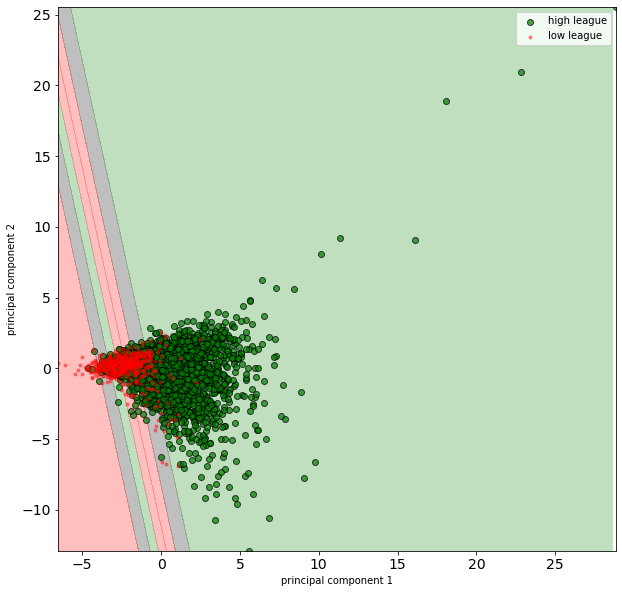

In [82]:
def plotDecisionBoundry(df,best_model):
    decomp = PCA(n_components=2)
    reduced = decomp.fit_transform(X, y)
    reduced = pd.DataFrame(reduced, columns=['pc_1', 'pc_2'])
    reduced = pd.concat([reduced, y], axis=1)
    model = best_model
    model.fit(reduced.drop('LowLeague', axis=1), reduced['LowLeague'])

    h=0.2

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced.iloc[:, 0].min(), reduced.iloc[:, 0].max()
    y_min, y_max = reduced.iloc[:, 1].min(), reduced.iloc[:, 1].max()
    # Meshgrid creation
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])   

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    proba = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    proba = proba[:, 1]
    thresholded = []
    for prob in proba:
        if prob >= .87:
            thresholded.append(1)
        else:
            thresholded.append(0)
    Z = np.array(proba).reshape(xx.shape)
    
    plt.figure(figsize=(10,10))
    # Plotting
    plt.contourf(xx, yy, Z, alpha=0.25, colors=['red', 'black', 'green', 'red'])
    highs = reduced[reduced['LowLeague']==1]
    lows = reduced[reduced['LowLeague']==0]
    plt.scatter(highs['pc_1'], highs['pc_2'], color='green', marker='o', alpha=0.7, edgecolor='k', linewidth=1.0, label='high league')
    plt.scatter(lows['pc_1'], lows['pc_2'], color='red', marker='.',alpha=0.4, label='low league')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('principal component 1')
    plt.ylabel('principal component 2')
    plt.legend(loc='best')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.show()
    
plotDecisionBoundry(starcraft, lr)